In [51]:
import pandas as pd
import numpy as np

from pandas_datareader.data import DataReader
import yfinance as yf
from datetime import datetime

import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

import seaborn as sns
sns.set_style('whitegrid')

import pandas_ta as ta

from ta.volatility import BollingerBands
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.momentum import StochRSIIndicator

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

import math

In [ ]:
# Define some hyperparameters
enc_seq_len = 4 # length of input given to encoder
shiftn_forward = 1 # shift forward
shift_backward = 1 # shift backward

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
})
src, trg, trg_y = split_to_sequences(enc_seq_len, 1, 1, df, "c")
print(src)
print(trg)
print(trg_y)

[[ 100  200  300  400]
 [ 200  300  400  500]
 [ 300  400  500  600]
 [ 400  500  600  700]
 [ 500  600  700  800]
 [ 600  700  800  900]
 [ 700  800  900 1000]
 [ 800  900 1000 1100]
 [ 900 1000 1100 1200]
 [1000 1100 1200 1300]
 [1100 1200 1300 1400]
 [1200 1300 1400 1500]
 [1300 1400 1500 1600]
 [1400 1500 1600 1700]]
[[ 400  500]
 [ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]]
[[ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]
 [1800 1900]]


In [389]:
# Load stock data
stock_list = ['NFLX', 'EPAM', 'AAPL']

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

for stock in stock_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [390]:
stock_data = [NFLX, EPAM, AAPL]

In [391]:
EPAM.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-16,171.039993,173.479996,170.720001,171.880005,171.880005,560000
2019-05-17,170.350006,171.339996,168.229996,169.520004,169.520004,258000
2019-05-20,167.910004,169.399994,164.369995,166.490005,166.490005,493800
2019-05-21,168.520004,170.679993,167.800003,170.149994,170.149994,451000
2019-05-22,169.770004,172.000000,168.789993,171.229996,171.229996,363300


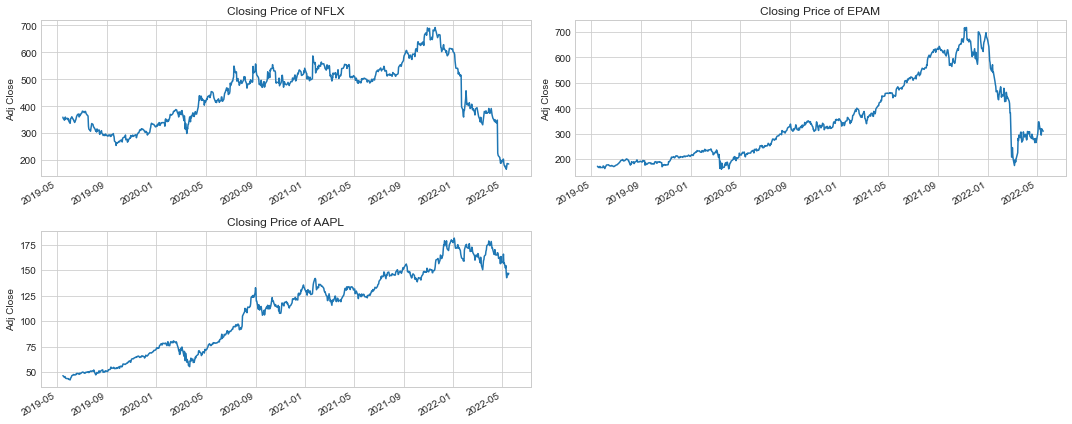

In [392]:
# Pot stock market prices
plt.figure(figsize=(15, 6))

for i, company in enumerate(stock_data, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {stock_list[i - 1]}")
    
plt.tight_layout()

In [393]:
for i, company in enumerate(stock_data, 1):
    company['Adj Close Change'] = company['Adj Close'].pct_change()
    company['Adj Close Change Log'] = np.log(1 + company['Adj Close Change'])
    company['Open Change'] = company['Open'].pct_change()
    company['High Change'] = company['High'].pct_change()
    company['Low Change'] = company['Low'].pct_change()

In [394]:
for i, company in enumerate(stock_data, 1):
    indicator_rci = RSIIndicator(close=company['Adj Close'])
    company['RSI'] = indicator_rci.rsi()


In [397]:
ema_day = [9, 21]

for ema in ema_day:
    for i, company in enumerate(stock_data, 1):
        column_name = f"EMA {ema}"
        company[column_name] = company['Adj Close'].ewm(span=ema, adjust=False).mean()

In [398]:
for i, company in enumerate(stock_data, 1):   
    company.dropna(how='any', axis=0, inplace=True)  

## Train network

In [309]:
# train model
def train(dataloader, model, loss_fn, optimizer, clip_gradient):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader, 1):
        optimizer.zero_grad()
        # Compute prediction error
        pred = model(X)
        pred = torch.squeeze(pred, dim=1)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        loss.backward()
        if clip_gradient is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_gradient)
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Train loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return train_loss

In [9]:
# test model
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            pred = torch.squeeze(pred, dim=1)
            loss = loss_fn(pred, y)
            test_loss += loss.item()
    test_loss /= num_batches
    print(f"\nTest loss: {test_loss:>8f}")
    return test_loss

In [310]:
def train_model(model, loader_train, loader_valid, epochs=30, lr=0.0001, clip_gradient = None):
    loss_fn = nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n-------------------------------")
        train_loss = train(loader_train, model, loss_fn, optimizer, clip_gradient)
        valid_loss = test(loader_valid, model, loss_fn)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
    return train_losses, valid_losses

In [11]:
def predict(model, loaders):
    model.eval()
    predictions = np.array([])
    original = np.array([])
    with torch.no_grad():
        for loader in loaders:
            for X, y in loader:
                print(f"X: {X}")
                print(f"y: {y}")
                pred = model(X)
                pred = torch.squeeze(pred, dim=1)
                predictions = np.append(predictions, pred.numpy())
                original = np.append(original, y.numpy())
    return original, predictions

In [275]:
def draw_prediction(original, predictions=None):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Transformer predictions", fontsize=22)
    st.set_y(0.92)

    ax11 = fig.add_subplot(311)
    ax11.plot(original, label='Original')
    if not predictions is None:
        ax11.plot(predictions, linewidth=3, label='Predicted')
    ax11.set_title("Training Data", fontsize=18)
    ax11.set_xlabel('Date')
    ax11.set_ylabel('Close price')
    ax11.legend(loc="best", fontsize=12)

In [13]:
def plot_losses(train_loss, valid_loss):
    fig = plt.figure(figsize=(15,20))
    st = fig.suptitle("Model loss (MSE)", fontsize=22)
    st.set_y(0.92)

    ax1 = fig.add_subplot(311)
    ax1.plot(train_loss[0:], label='Training loss (MSE)')
    ax1.plot(valid_loss[0:], label='Validation loss (MSE)')
    ax1.set_title("Model loss", fontsize=18)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend(loc="best", fontsize=12) 

## Prepare data

In [14]:
def split_data(df, valid_split = 0.1, test_split=0.1):
    indexes = sorted(df.index.values)
    # first index of test data
    test_index = indexes[-int(test_split * len(indexes))]
    # first index of validation data
    valid_index = indexes[-int((test_split + valid_split) * len(indexes))]

    # split data to train, test and validation dataframes
    train_df = df[(df.index < valid_index)]
    # valid_df = df[np.logical_and(company.index >= valid_index, company.index < test_index)]
    valid_df = df[(df.index >= valid_index) & (df.index < test_index)]
    test_df = df[(df.index >= test_index)]
    print(f"Train splitted data shape: {train_df.shape}")
    print(f"Valid splitted data shape: {valid_df.shape}")
    print(f"Test splitted data shape: {test_df.shape}")
    return train_df, valid_df, test_df

In [ ]:
# Define some hyperparameters
enc_seq_len = 4 # length of input given to encoder
shiftn_forward = 1 # shift forward
shift_backward = 1 # shift backward

df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]
})
src, trg, trg_y = split_to_sequences(enc_seq_len, 1, 1, df, "c")
print(src)
print(trg)
print(trg_y)

[[ 100  200  300  400]
 [ 200  300  400  500]
 [ 300  400  500  600]
 [ 400  500  600  700]
 [ 500  600  700  800]
 [ 600  700  800  900]
 [ 700  800  900 1000]
 [ 800  900 1000 1100]
 [ 900 1000 1100 1200]
 [1000 1100 1200 1300]
 [1100 1200 1300 1400]
 [1200 1300 1400 1500]
 [1300 1400 1500 1600]
 [1400 1500 1600 1700]]
[[ 400  500]
 [ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]]
[[ 500  600]
 [ 600  700]
 [ 700  800]
 [ 800  900]
 [ 900 1000]
 [1000 1100]
 [1100 1200]
 [1200 1300]
 [1300 1400]
 [1400 1500]
 [1500 1600]
 [1600 1700]
 [1700 1800]
 [1800 1900]]


In [15]:
def draw_feature_split(column, train_df, valid_df, test_df):
    fig = plt.figure(figsize=(15,12))
    st = fig.suptitle("Data Separation", fontsize=20)
    st.set_y(0.95)
    
    ax1 = fig.add_subplot(211)
    ax1.plot(np.arange(train_df.values.shape[0]), train_df[column], label='Training data')
    ax1.plot(np.arange(train_df.values.shape[0], train_df.values.shape[0] + valid_df.values.shape[0]), valid_df[column], label='Validation data')
    ax1.plot(
        np.arange(
            train_df.values.shape[0] + valid_df.values.shape[0],
            train_df.values.shape[0] + valid_df.values.shape[0] + test_df.values.shape[0]
        ), test_df[column], label='Test data')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(column)
    ax1.set_title(column, fontsize=18)
    ax1.legend(loc="best", fontsize=12) 

In [16]:
df = pd.DataFrame(np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]), columns=['a'])
train_df, valid_df, test_df = split_data(df)
print(f" Train shape {train_df.shape}")
print(f" Valid shape {valid_df.shape}")
print(f" Test shape {test_df.shape}")

Train splitted data shape: (8, 1)
Valid splitted data shape: (1, 1)
Test splitted data shape: (1, 1)
 Train shape (8, 1)
 Valid shape (1, 1)
 Test shape (1, 1)


In [17]:
def normalize_data(df, column_scalers, is_fit=False):
    features = pd.DataFrame()
    for scaler, columns in column_scalers:
        if is_fit:
            values = df[columns].to_numpy().flatten()
            scaler.fit(values.reshape(-1, 1))
        for column in columns:
            data = df[column].values.reshape(-1, 1)
            scaled_data = scaler.transform(data)
            features["ft_" + column] = scaled_data.reshape(1, -1)[0]
    return features


In [18]:
df = pd.DataFrame(data={
    "aa": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "bb": [10, 20, 30, 40, 50, 60, 70, 80, 90],
    "cc": [100, 200, 300, 400, 500, 600, 700, 800, 900]
})
scalers = [
    (MinMaxScaler(), ["aa"]),
    (MinMaxScaler(), ["bb", "cc"])
]
features_df = normalize_data(df, scalers, True)
print(features_df.head())
print(features_df.describe())

   ft_aa     ft_bb     ft_cc
0  0.000  0.000000  0.101124
1  0.125  0.011236  0.213483
2  0.250  0.022472  0.325843
3  0.375  0.033708  0.438202
4  0.500  0.044944  0.550562
          ft_aa     ft_bb     ft_cc
count  9.000000  9.000000  9.000000
mean   0.500000  0.044944  0.550562
std    0.342327  0.030771  0.307709
min    0.000000  0.000000  0.101124
25%    0.250000  0.022472  0.325843
50%    0.500000  0.044944  0.550562
75%    0.750000  0.067416  0.775281
max    1.000000  0.089888  1.000000


In [19]:
def split_to_sequences(seq_len, features, target_column):
    print(f"Split to sequence lenght {seq_len} features shape {features.shape} with target {target_column}")
    X_train, y_train = [], []  
    for i in range(seq_len, len(features)):
        x_train_seq = features[i-seq_len:i]
        X_train.append(x_train_seq)

        y_train_seq = features[target_column].to_numpy()[i]
        y_train.append(y_train_seq)
    print(f"X sequence lenght: {len(X_train)}")
    print(f"y sequence lenght: {len(y_train)}")
    return np.array(X_train), np.array(y_train)

In [20]:
def create_loader(X, y, batch_size = 64, shuffle=False):
    x_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).float()
    dataset = TensorDataset(x_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)


In [21]:
df = pd.DataFrame(data={
    "a": [1, 2, 3, 4, 5, 6, 7, 8, 9],
    "b": [10, 20, 30, 40, 50, 60, 70, 80, 90],
    "c": [100, 200, 300, 400, 500, 600, 700, 800, 900]
})
X, y = split_to_sequences(5, df, "c")
print(X)
print(y)

loader = create_loader(X, y, 3)
(X, y) = next(iter(loader))
print(X)
print(y)

Split to sequence lenght 5 features shape (9, 3) with target c
X sequence lenght: 4
y sequence lenght: 4
[[[  1  10 100]
  [  2  20 200]
  [  3  30 300]
  [  4  40 400]
  [  5  50 500]]

 [[  2  20 200]
  [  3  30 300]
  [  4  40 400]
  [  5  50 500]
  [  6  60 600]]

 [[  3  30 300]
  [  4  40 400]
  [  5  50 500]
  [  6  60 600]
  [  7  70 700]]

 [[  4  40 400]
  [  5  50 500]
  [  6  60 600]
  [  7  70 700]
  [  8  80 800]]]
[600 700 800 900]
tensor([[[  1.,  10., 100.],
         [  2.,  20., 200.],
         [  3.,  30., 300.],
         [  4.,  40., 400.],
         [  5.,  50., 500.]],

        [[  2.,  20., 200.],
         [  3.,  30., 300.],
         [  4.,  40., 400.],
         [  5.,  50., 500.],
         [  6.,  60., 600.]],

        [[  3.,  30., 300.],
         [  4.,  40., 400.],
         [  5.,  50., 500.],
         [  6.,  60., 600.],
         [  7.,  70., 700.]]])
tensor([600., 700., 800.])


In [300]:
def prepare_data(df, scalers, seq_len = 64, target_column = "Adj Close"):
    train, valid, test = split_data(df)
    train = normalize_data(train, scalers, True)
    valid = normalize_data(valid, scalers)
    test = normalize_data(test, scalers)
    draw_feature_split(target_column, train, valid, test)
    X_train, y_train = split_to_sequences(seq_len, train, target_column)
    X_valid, y_valid = split_to_sequences(seq_len, valid, target_column)
    X_test, y_test = split_to_sequences(seq_len, test, target_column)
    loader_train = create_loader(X_train, y_train, shuffle=False)
    loader_train_normal = create_loader(X_train, y_train)
    loader_valid = create_loader(X_valid, y_valid)
    loader_test = create_loader(X_test, y_test)
    return loader_train, loader_valid, loader_test, loader_train_normal
    
    

In [399]:
EPAM.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close Change,Adj Close Change Log,Open Change,High Change,Low Change,RSI,EMA 9,EMA 21
Date,,,,,,,,,,,,,,
2019-06-05,170.000000,170.509995,166.970001,170.160004,170.160004,389500,0.011773,0.011704,0.029118,0.013432,0.025110,50.588714,168.810229,169.549031
2019-06-06,170.289993,173.270004,169.289993,172.820007,172.820007,329800,0.015632,0.015511,0.001706,0.016187,0.013895,55.104756,169.612185,169.846392
2019-06-07,174.000000,177.839996,173.649994,176.750000,176.750000,361000,0.022740,0.022486,0.021786,0.026375,0.025755,60.804578,171.039748,170.473993
2019-06-10,178.380005,179.360001,175.039993,177.110001,177.110001,426800,0.002037,0.002035,0.025172,0.008547,0.008005,61.289405,172.253798,171.077266
2019-06-11,179.080002,179.610001,175.610001,177.449997,177.449997,424700,0.001920,0.001918,0.003924,0.001394,0.003256,61.770364,173.293038,171.656605


Train splitted data shape: (596, 3)
Valid splitted data shape: (75, 3)
Test splitted data shape: (74, 3)
Split to sequence lenght 64 features shape (596, 3) with target ft_Adj Close
X sequence lenght: 532
y sequence lenght: 532
Split to sequence lenght 64 features shape (75, 3) with target ft_Adj Close
X sequence lenght: 11
y sequence lenght: 11
Split to sequence lenght 64 features shape (74, 3) with target ft_Adj Close
X sequence lenght: 10
y sequence lenght: 10


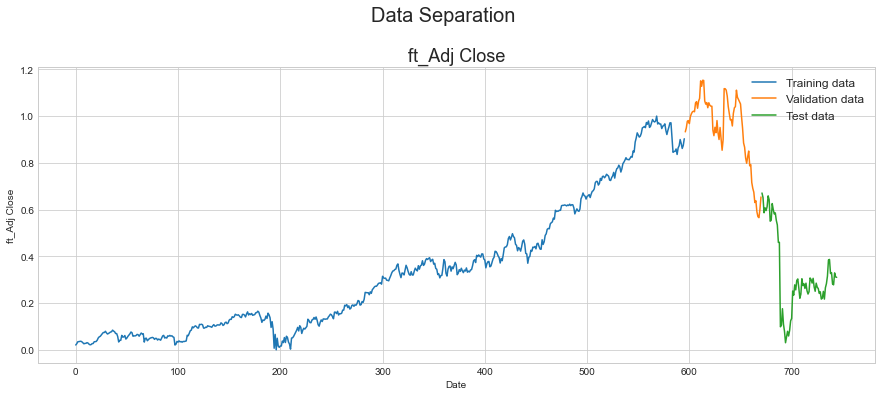

In [410]:
# feature_columns = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
# feature_columns = ["Adj Close", "Volume", "Adj Close Change"]
feature_columns = ["Adj Close", "Volume", "Adj Close Change"]
seq_len = 64
scalers = [
    (MinMaxScaler(), ["Adj Close"]),
    (MinMaxScaler(), ["Volume"]),
    (MinMaxScaler(), ["Adj Close Change"])
]

# features_df = normalize_data(EPAM, scalers)
loader_train, loader_valid, loader_test, loader_train_normal = prepare_data(EPAM[feature_columns], scalers, seq_len = seq_len, target_column = "ft_Adj Close")

Train splitted data shape: (607, 3)
Valid splitted data shape: (76, 3)
Test splitted data shape: (75, 3)
Split to sequence lenght 5 features shape (607, 3) with target ft_Adj Close Change
X sequence lenght: 602
y sequence lenght: 602
Split to sequence lenght 5 features shape (76, 3) with target ft_Adj Close Change
X sequence lenght: 71
y sequence lenght: 71
Split to sequence lenght 5 features shape (75, 3) with target ft_Adj Close Change
X sequence lenght: 70
y sequence lenght: 70


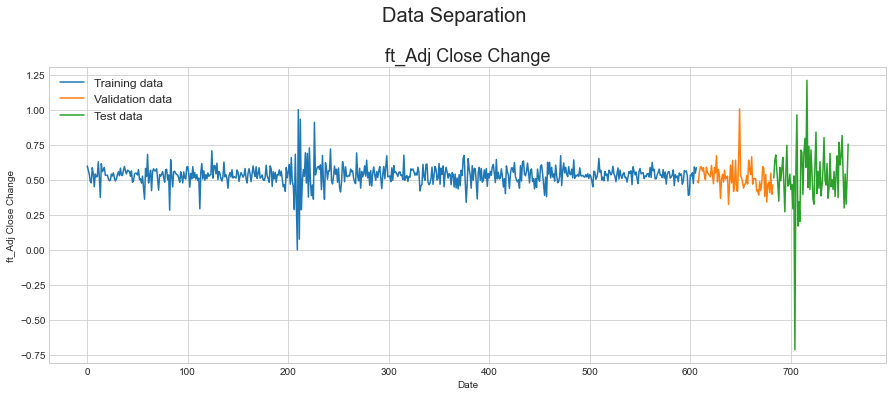

In [237]:
# train model on percent change
# feature_columns = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
# feature_columns = ["Adj Close", "Volume", "Adj Close Change"]
feature_columns = ["Adj Close", "Volume", "Adj Close Change"]
seq_len = 5
scalers = [
    (MinMaxScaler(), ["Adj Close"]),
    (MinMaxScaler(), ["Volume"]),
    (MinMaxScaler(), ["Adj Close Change"])
]

# features_df = normalize_data(EPAM, scalers)
loader_train, loader_valid, loader_test, loader_train_normal = prepare_data(EPAM[feature_columns], scalers, seq_len = seq_len, target_column = "ft_Adj Close Change")

In [26]:
EPAM.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 758 entries, 2019-05-14 to 2022-05-13
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Open              758 non-null    float64
 1   High              758 non-null    float64
 2   Low               758 non-null    float64
 3   Close             758 non-null    float64
 4   Adj Close         758 non-null    float64
 5   Volume            758 non-null    int64  
 6   Adj Close Change  758 non-null    float64
 7   Open Change       758 non-null    float64
 8   High Change       758 non-null    float64
 9   Low Change        758 non-null    float64
dtypes: float64(9), int64(1)
memory usage: 65.1 KB


In [343]:
EPAM.head()

,Open,High,Low,Close,Adj Close,Volume,Adj Close Change,Adj Close Change Log,Open Change,High Change,Low Change,RSI
Date,,,,,,,,,,,,
2019-06-03,172.600006,173.000000,162.490005,162.869995,162.869995,932500,-0.056318,-0.057967,0.011605,-0.002882,-0.039487,38.442033
2019-06-04,165.190002,168.250000,162.880005,168.179993,168.179993,780600,0.032603,0.032082,-0.042932,-0.027457,0.002400,49.364351
2019-06-05,170.000000,170.509995,166.970001,170.160004,170.160004,389500,0.011773,0.011704,0.029118,0.013432,0.025110,52.732209
2019-06-06,170.289993,173.270004,169.289993,172.820007,172.820007,329800,0.015632,0.015511,0.001706,0.016187,0.013895,56.881382
2019-06-07,174.000000,177.839996,173.649994,176.750000,176.750000,361000,0.022740,0.022486,0.021786,0.026375,0.025755,62.165564


Train splitted data shape: (596, 4)
Valid splitted data shape: (75, 4)
Test splitted data shape: (74, 4)
Split to sequence lenght 64 features shape (596, 4) with target ft_Adj Close
X sequence lenght: 532
y sequence lenght: 532
Split to sequence lenght 64 features shape (75, 4) with target ft_Adj Close
X sequence lenght: 11
y sequence lenght: 11
Split to sequence lenght 64 features shape (74, 4) with target ft_Adj Close
X sequence lenght: 10
y sequence lenght: 10


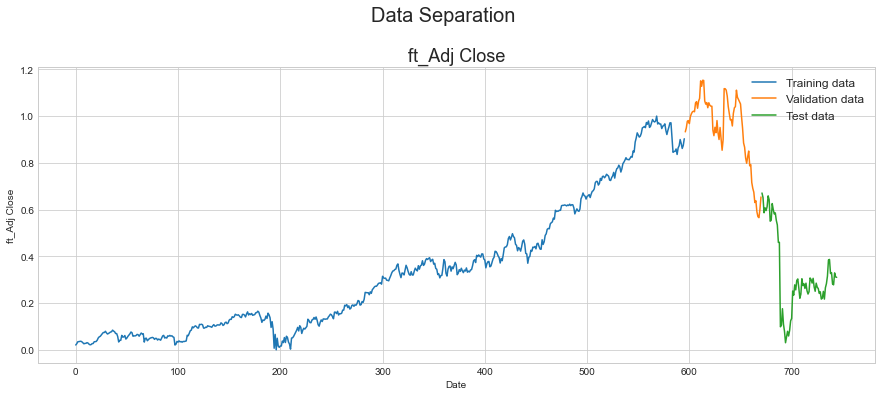

In [417]:
# train model on percent change
# feature_columns = ["Open", "High", "Low",	"Close", "Adj Close", "Volume"]
# feature_columns = ["Adj Close", "Volume", "Adj Close Change"]
feature_columns = ["Adj Close", "Volume", "Adj Close Change Log", "RSI"]
seq_len = 64
scalers = [
    (MinMaxScaler(), ["Adj Close"]),
    (MinMaxScaler(), ["Volume"]),
    (MinMaxScaler(), ["Adj Close Change Log"]),
    (MinMaxScaler(), ["RSI"])
]

# features_df = normalize_data(EPAM, scalers)
loader_train, loader_valid, loader_test, loader_train_normal = prepare_data(EPAM[feature_columns], scalers, seq_len = seq_len, target_column = "ft_Adj Close")

## Simple network

In [82]:
class Model(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.1):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(Model, self).__init__()

        # number of features should be divisible by num_heads
        num_heads=num_features
        # layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, dropout=dropout, activation="gelu")
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.avg_poll = nn.MaxPool1d(num_features)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(sequence_lenght, 64)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(64, 1)


    def forward(self, input):
        x = input
        x = self.encoder(x)
        x = self.avg_poll(x)
        x = torch.squeeze(x, dim=2)
        x = self.dropout(x)
        x = F.gelu(self.linear(x))
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

In [83]:
sequence_lenght = 32
feature_num = 22
batch_size = 64
test_model = Model(sequence_lenght, feature_num)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
output = test_model(input)
print(f"Output shape: {output.shape}")

Input shape: torch.Size([64, 32, 22])
Output shape: torch.Size([64, 1])


Epoch 1
-------------------------------
Train loss: 0.219185

Test loss: 0.155980
Epoch 2
-------------------------------
Train loss: 0.059276

Test loss: 0.107745
Epoch 3
-------------------------------
Train loss: 0.044229

Test loss: 0.110076
Epoch 4
-------------------------------
Train loss: 0.036867

Test loss: 0.100124
Epoch 5
-------------------------------
Train loss: 0.036616

Test loss: 0.095391
Epoch 6
-------------------------------
Train loss: 0.032859

Test loss: 0.095603
Epoch 7
-------------------------------
Train loss: 0.027524

Test loss: 0.094017
Epoch 8
-------------------------------
Train loss: 0.025779

Test loss: 0.092038
Epoch 9
-------------------------------
Train loss: 0.024042

Test loss: 0.090532
Epoch 10
-------------------------------
Train loss: 0.026417

Test loss: 0.089283
Epoch 11
-------------------------------
Train loss: 0.024459

Test loss: 0.089082
Epoch 12
-------------------------------
Train loss: 0.022881

Test loss: 0.090194
Epoch 13
----

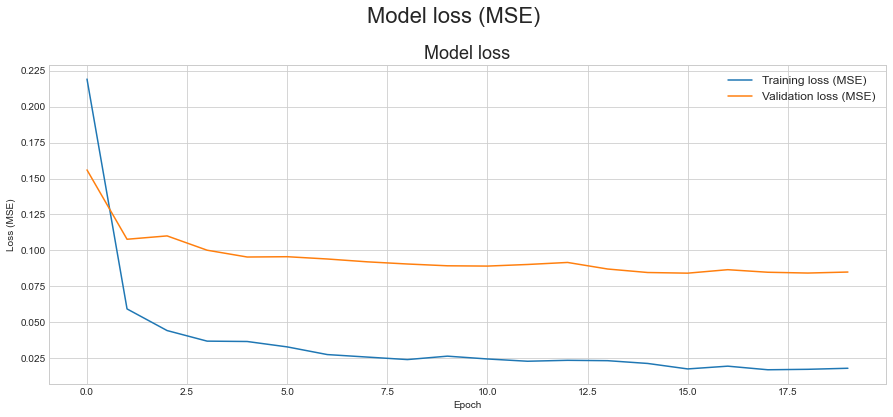

In [87]:

feature_num = 3
epochs = 20
simple_model = Model(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model, loader_train, loader_valid, epochs=epochs, lr=0.001)
plot_losses(train_losses, valid_losses)


X: tensor([[[0.2367, 0.1134, 0.4015],
         [0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         ...,
         [0.2134, 0.1807, 0.3287],
         [0.2570, 0.1818, 0.5759],
         [0.2630, 0.1044, 0.4215]],

        [[0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         ...,
         [0.2570, 0.1818, 0.5759],
         [0.2630, 0.1044, 0.4215],
         [0.2667, 0.0691, 0.4120]],

        [[0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340],
         ...,
         [0.2630, 0.1044, 0.4215],
         [0.2667, 0.0691, 0.4120],
         [0.2764, 0.0979, 0.4353]],

        ...,

        [[0.1413, 0.1133, 0.3191],
         [0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146],
         ...,
         [0.0967, 0.0758, 0.4070],
         [0.1097, 0.0874, 0.4593],
         [0.1018, 0.0890, 0.3614]],

        [[0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146],
         

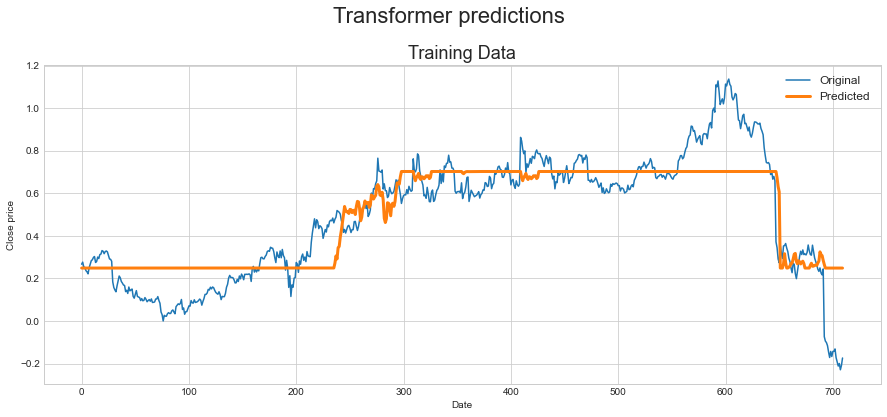

In [85]:
original, predictions = predict(simple_model, [loader_train_normal, loader_valid, loader_test])
draw_prediction(original, predictions)
print(original)
print(predictions)

## Simple Network + Conv After Transformer

In [178]:
class ModelConvTransformer(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=6, dropout=0.1):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(ModelConvTransformer, self).__init__()

        # number of features should be divisible by num_heads
        num_heads=num_features
        # layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.conv = nn.Conv1d(sequence_lenght, int(2*sequence_lenght), 1)
        self.poll = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(int(2*sequence_lenght), 512, 1)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(512, 64)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(64, 1)

        # convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
        # processed = GlobalMaxPooling1D()(convolved)
        # #dense layer with dropout regularization
        # compressed = Dense(50, activation="tanh")(processed)


    def forward(self, input):
        x = input
        x = self.encoder(x)
        x = self.conv(x)
        x = self.poll(x)
        x = self.conv1(x)
        x = torch.squeeze(x, dim=2)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

In [164]:
conv = nn.Conv1d(3, 6, 1)
conv1 = nn.Conv1d(6, 16, 1)
poll = nn.MaxPool1d(2)
input = torch.randn(2, 3, 2)
print(f"Input {input.shape}")
x = conv(input)
print(f"Output conv shape {x.shape}")
x = poll(x)
print(f"Output poll shape {x.shape}")
x = conv1(x)
print(f"Output conv1 shape {x.shape}")
x = torch.squeeze(x, dim=2)
print(f"Pull shape {x.shape}")

Input torch.Size([2, 3, 2])
Output conv shape torch.Size([2, 6, 2])
Output poll shape torch.Size([2, 6, 1])
Output conv1 shape torch.Size([2, 16, 1])
Pull shape torch.Size([2, 16])


Epoch 1
-------------------------------
Train loss: 0.250050

Test loss: 0.370154
Epoch 2
-------------------------------
Train loss: 0.113755

Test loss: 0.217652
Epoch 3
-------------------------------
Train loss: 0.066742

Test loss: 0.137572
Epoch 4
-------------------------------
Train loss: 0.041005

Test loss: 0.091729
Epoch 5
-------------------------------
Train loss: 0.034698

Test loss: 0.068052
Epoch 6
-------------------------------
Train loss: 0.025156

Test loss: 0.063870
Epoch 7
-------------------------------
Train loss: 0.025076

Test loss: 0.066666
Epoch 8
-------------------------------
Train loss: 0.020088

Test loss: 0.064747
Epoch 9
-------------------------------
Train loss: 0.020882

Test loss: 0.061832
Epoch 10
-------------------------------
Train loss: 0.020179

Test loss: 0.058429
Epoch 11
-------------------------------
Train loss: 0.022926

Test loss: 0.058030
Epoch 12
-------------------------------
Train loss: 0.020367

Test loss: 0.057995
Epoch 13
----

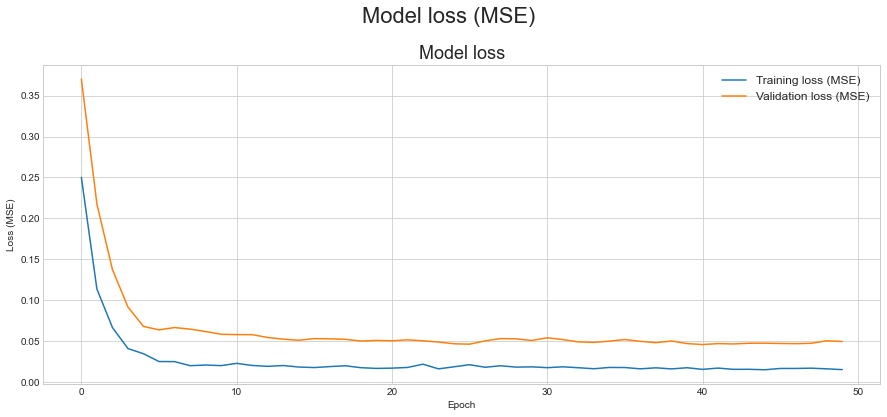

In [185]:
# default parameters
# lr=0.001
feature_num = 3
epochs = 50
simple_model_transformer_conv = ModelConvTransformer(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model_transformer_conv, loader_train, loader_valid, epochs=epochs, lr=0.0001)
plot_losses(train_losses, valid_losses)

X: tensor([[[0.2367, 0.1134, 0.4015],
         [0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340]],

        [[0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340],
         [0.2592, 0.0777, 0.4611]],

        [[0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340],
         [0.2592, 0.0777, 0.4611],
         [0.2734, 0.1370, 0.4530]],

        [[0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340],
         [0.2592, 0.0777, 0.4611],
         [0.2734, 0.1370, 0.4530],
         [0.2539, 0.1209, 0.3232]],

        [[0.2432, 0.0937, 0.3340],
         [0.2592, 0.0777, 0.4611],
         [0.2734, 0.1370, 0.4530],
         [0.2539, 0.1209, 0.3232],
         [0.2596, 0.0724, 0.4200]],

        [[0.2592, 0.0777, 0.4611],
         [0.2734, 0.1370, 0.4530],
         [0.2539, 0.1209, 0.3232],
       

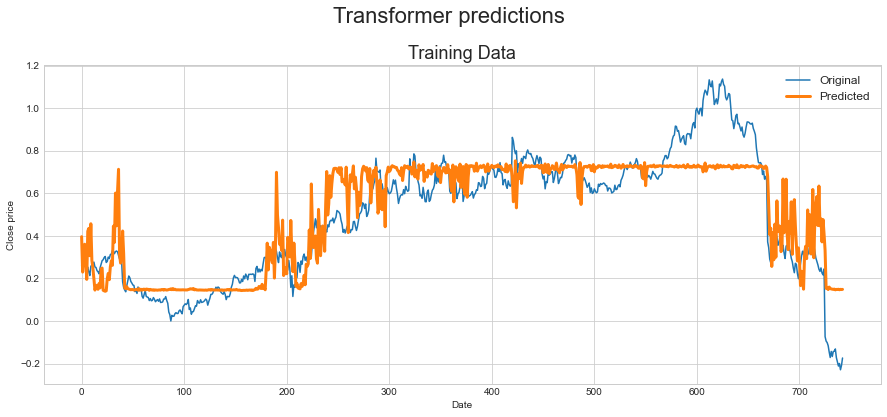

In [186]:
original, predictions = predict(simple_model_transformer_conv, [loader_train, loader_valid, loader_test])
draw_prediction(original, predictions)
print(original)
print(predictions)

## Simple Network + Feature extractor

In [249]:
class ModelExtractor(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.2):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(ModelExtractor, self).__init__()

        # number of features should be divisible by num_heads
        num_heads=num_features
        # layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, dropout=dropout)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.linear = nn.Linear(num_features, 128)
        self.dropout = nn.Dropout(p=dropout)
        self.avg_poll = nn.AvgPool1d(2)
        self.linear1 = nn.Linear(64, 32)
        self.dropout1 = nn.Dropout(p=dropout)
        self.avg_poll1 = nn.AvgPool1d(32)
        self.linear2 = nn.Linear(64, 1)
        self.dropout2 = nn.Dropout(p=dropout)


    def forward(self, input):
        x = input
        x = self.encoder(x)
        x = self.dropout(x)
        x = F.leaky_relu(self.linear(x))
        x = self.avg_poll(x)
        x = self.dropout1(x)
        x = F.leaky_relu(self.linear1(x))
        x = self.avg_poll1(x)
        x = torch.squeeze(x, dim=2)
        x = self.dropout2(x)
        x = self.linear2(x)
        return x

In [250]:
sequence_lenght = 64
feature_num = 4
batch_size = 64
# number of features should be divisible by num_heads
test_model = ModelExtractor(sequence_lenght, feature_num)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
output = test_model(input)
print(f"Output shape: {output.shape}")

Input shape: torch.Size([64, 64, 4])
Output shape: torch.Size([64, 1])


Epoch 1
-------------------------------
Train loss: 0.313121

Test loss: 0.735350
Epoch 2
-------------------------------
Train loss: 0.267354

Test loss: 0.633857
Epoch 3
-------------------------------
Train loss: 0.177957

Test loss: 0.398451
Epoch 4
-------------------------------
Train loss: 0.080867

Test loss: 0.163154
Epoch 5
-------------------------------
Train loss: 0.096225

Test loss: 0.120558
Epoch 6
-------------------------------
Train loss: 0.114505

Test loss: 0.161817
Epoch 7
-------------------------------
Train loss: 0.106840

Test loss: 0.190106
Epoch 8
-------------------------------
Train loss: 0.097508

Test loss: 0.189024
Epoch 9
-------------------------------
Train loss: 0.098493

Test loss: 0.181917
Epoch 10
-------------------------------
Train loss: 0.096830

Test loss: 0.177296
Epoch 11
-------------------------------
Train loss: 0.098882

Test loss: 0.176015
Epoch 12
-------------------------------
Train loss: 0.103741

Test loss: 0.176156
Epoch 13
----

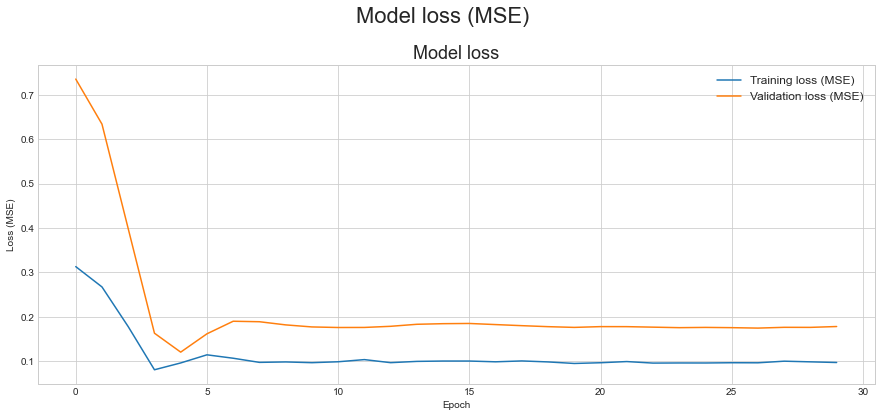

In [252]:
feature_num = 1
epochs = 30
simple_model_extractor = ModelExtractor(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model_extractor, loader_train, loader_valid, epochs=epochs, lr=0.001)
plot_losses(train_losses, valid_losses)

X: tensor([[[0.0200],
         [0.0228],
         [0.0079],
         ...,
         [0.0409],
         [0.0405],
         [0.0618]],

        [[0.0228],
         [0.0079],
         [0.0169],
         ...,
         [0.0405],
         [0.0618],
         [0.0546]],

        [[0.0079],
         [0.0169],
         [0.0226],
         ...,
         [0.0618],
         [0.0546],
         [0.0551]],

        ...,

        [[0.0409],
         [0.0405],
         [0.0618],
         ...,
         [0.0328],
         [0.0358],
         [0.0355]],

        [[0.0405],
         [0.0618],
         [0.0546],
         ...,
         [0.0358],
         [0.0355],
         [0.0366]],

        [[0.0618],
         [0.0546],
         [0.0551],
         ...,
         [0.0355],
         [0.0366],
         [0.0378]]])
y: tensor([0.0546, 0.0551, 0.0610, 0.0460, 0.0504, 0.0577, 0.0631, 0.0686, 0.0762,
        0.0732, 0.0582, 0.0597, 0.0595, 0.0613, 0.0659, 0.0646, 0.0582, 0.0648,
        0.0718, 0.0678, 0.0690, 0.0331, 

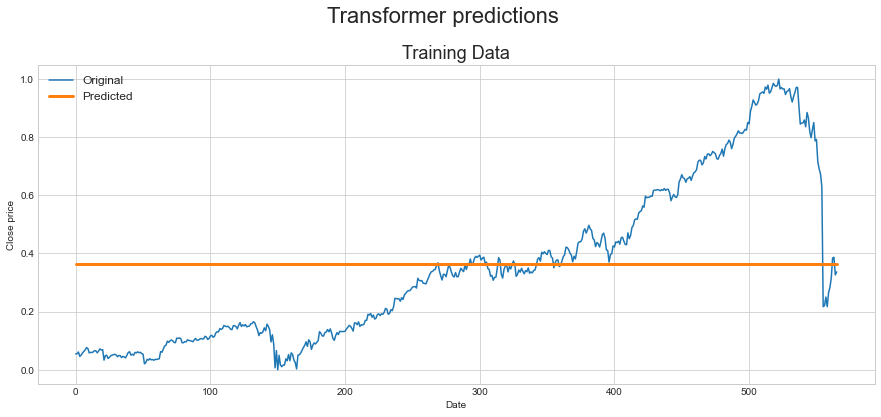

In [253]:
original, predictions = predict(simple_model_extractor, [loader_train, loader_valid, loader_test])
draw_prediction(original, predictions)
print(original)
print(predictions)

## Simple Network + Positional encodding

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x.transpose(0, 1) # convert tensor shape to [seq_len, batch_size, embedding_dim]
        x = x + self.pe[:x.size(0)]
        x = x.transpose(1, 0)
        return self.dropout(x)

In [6]:
sequence_lenght = 3
feature_num = 4
batch_size = 2
# number of features should be divisible by num_heads
test_encoder = PositionalEncoding(feature_num, max_len = sequence_lenght)
input = torch.rand(batch_size, sequence_lenght, feature_num)
print(f"Input shape: {input.shape}")
print(input)
output = test_encoder(input)
print(f"Output shape: {output.shape}")
print(output)

Input shape: torch.Size([2, 3, 4])
tensor([[[0.6871, 0.5015, 0.1403, 0.7345],
         [0.3647, 0.3933, 0.3714, 0.8356],
         [0.0194, 0.8352, 0.9525, 0.4513]],

        [[0.3383, 0.6630, 0.7754, 0.2009],
         [0.7760, 0.4692, 0.8807, 0.4641],
         [0.6475, 0.6836, 0.6358, 0.2947]]])
Output shape: torch.Size([2, 3, 4])
tensor([[[0.7634, 1.6684, 0.1559, 1.9272],
         [1.3402, 1.0374, 0.4238, 2.0395],
         [1.0319, 0.4656, 1.0805, 1.6123]],

        [[0.3758, 1.8478, 0.8616, 1.3343],
         [1.7972, 1.1217, 0.9897, 0.0000],
         [1.7297, 0.2972, 0.7286, 1.4383]]])


In [133]:
class PositionalModel(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.1):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(PositionalModel, self).__init__()

        # number of features should be divisible by num_heads
        num_heads=num_features
        # layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, dropout=dropout, norm_first=False)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.pos_encoder = PositionalEncoding(num_features, dropout)
        self.avg_poll = nn.AvgPool1d(num_features)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(sequence_lenght, 64)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(64, 1)


    def forward(self, input):
        x = input
        x = self.pos_encoder(x)
        x = self.encoder(x)
        x = self.avg_poll(x)
        # x = torch.squeeze(x, dim=2)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

Epoch 1
-------------------------------
Train loss: 0.155479

Test loss: 0.601392
Epoch 2
-------------------------------
Train loss: 0.116382

Test loss: 0.457092
Epoch 3
-------------------------------
Train loss: 0.083061

Test loss: 0.256027
Epoch 4
-------------------------------
Train loss: 0.078006

Test loss: 0.298807
Epoch 5
-------------------------------
Train loss: 0.078083

Test loss: 0.297665
Epoch 6
-------------------------------
Train loss: 0.076413

Test loss: 0.295355
Epoch 7
-------------------------------
Train loss: 0.076742

Test loss: 0.282525
Epoch 8
-------------------------------
Train loss: 0.076493

Test loss: 0.296958
Epoch 9
-------------------------------
Train loss: 0.075920

Test loss: 0.280368
Epoch 10
-------------------------------
Train loss: 0.076296

Test loss: 0.292188
Epoch 11
-------------------------------
Train loss: 0.075926

Test loss: 0.287331
Epoch 12
-------------------------------
Train loss: 0.074350

Test loss: 0.282287
Epoch 13
----

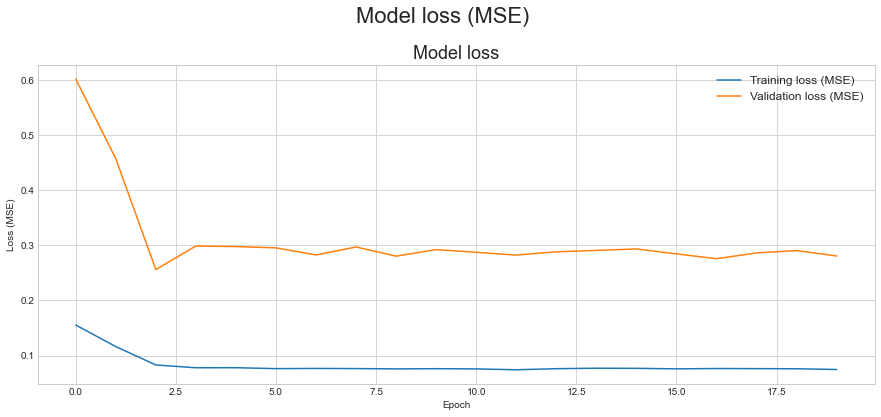

In [134]:
feature_num = 2 # positional encoder not work with more than 2 features
epochs = 20
simple_model_positional = PositionalModel(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model_positional, loader_train, loader_valid, epochs=epochs, lr=0.001)
plot_losses(train_losses, valid_losses)

In [162]:
original, predictions = predict(simple_model_positional, [loader_train, loader_valid, loader_test])
draw_prediction(original, predictions)
# print(original)
print(f"Pred: {predictions}")

X: tensor([[[0.3958, 0.0775],
         [0.4217, 0.0726],
         [0.4203, 0.0708],
         ...,
         [0.5916, 0.0555],
         [0.5935, 0.0783],
         [0.5934, 0.0559]],

        [[0.0268, 0.1450],
         [0.0343, 0.1117],
         [0.0352, 0.0946],
         ...,
         [0.0490, 0.0179],
         [0.0486, 0.0317],
         [0.0419, 0.0566]],

        [[0.1077, 0.0186],
         [0.1163, 0.0446],
         [0.1185, 0.0401],
         ...,
         [0.0581, 0.1173],
         [0.0528, 0.1659],
         [0.0332, 0.0519]],

        ...,

        [[0.0596, 0.0801],
         [0.0619, 0.1276],
         [0.0504, 0.0600],
         ...,
         [0.1163, 0.0446],
         [0.1185, 0.0401],
         [0.1119, 0.1356]],

        [[0.6450, 0.2381],
         [0.6569, 0.0285],
         [0.6590, 0.0893],
         ...,
         [0.9792, 0.1398],
         [0.9516, 0.1269],
         [0.9564, 0.1133]],

        [[0.1883, 0.1351],
         [0.1936, 0.1002],
         [0.1808, 0.0788],
         ...

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x64 and 32x64)

## Simple Network + Time2Vec

In [187]:
class Time2Vector(nn.Module):
    
    def __init__(self, sequnce_size: int = 1, feature_num: int = 1):
        """
        Apply time to vector embedding.

        Args:
            sequnce_size: size of event sequence in time
            feature_num: number of features in sequence
        """
        super(Time2Vector, self).__init__()
        
        self.sequnce_size = sequnce_size
        self.feature_num = feature_num
        self.weights_linear = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_linear = torch.nn.Parameter(torch.empty(feature_num))
        self.weights_periodic = torch.nn.Parameter(torch.empty((sequnce_size, feature_num)))
        self.bias_periodic = torch.nn.Parameter(torch.empty(feature_num))
        self.func_periodic = torch.sin
        self.reset_parameters()

    def reset_parameters(self) -> None:
        """
        Initialize component weights
        """
        # init linear weights
        nn.init.uniform_(self.weights_linear, -1, 1)
        nn.init.uniform_(self.bias_linear, -1, 1)
        
        # init periodic weights
        nn.init.uniform_(self.weights_periodic, -1, 1)
        nn.init.uniform_(self.bias_periodic, -1, 1)

    def forward(self, x):
        weights_linear = self.weights_linear.expand(x.shape[0], self.sequnce_size, self.feature_num)
        linear = torch.mul(weights_linear, x) + self.bias_linear
        weights_periodic = self.weights_periodic.expand(x.shape[0], self.sequnce_size, self.feature_num)
        periodic = self.func_periodic(torch.mul(weights_periodic, x) + self.bias_periodic)
        return torch.cat([linear, periodic], 2)

In [212]:
class Time2VecModel(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.2):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(Time2VecModel, self).__init__()

        # number of features should be divisible by num_heads
        # num_heads=num_features
        self.time_embedding = Time2Vector(sequence_lenght, num_features)
        encoder_features = num_features + num_features * 2
        num_heads=encoder_features
        # layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, dropout=dropout)
        # nn.AvgPool1d kernel_size equal to the dimensions of the feature maps.
        # self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers, norm=nn.AvgPool1d(encoder_features))
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.avg_poll = nn.AvgPool1d(encoder_features) # average
        # self.avg_poll = nn.AdaptiveAvgPool1d(1) # adaptive
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(sequence_lenght, 128)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(128, 1)


    def forward(self, input):
        # print(f"Raw input shape: {input.shape}")
        x = self.time_embedding(input)
        # print(f"Embeddings shape: {x.shape}")
        x = torch.cat([input, x], 2)
        # print(f"Input data with time features shape: {x.shape}")
        x = self.encoder(x)
        # print(f"Encoder output shape: {x.shape}")
        # print(f"Encoder output shape: {x[:5]}")
        x = self.avg_poll(x) # ??? do we really need this pooling
        # print(f"Avg pool output shape: {x.shape}")
        # print(f"Avg pool output: {x}")
        x = torch.squeeze(x, dim=2) # reduce dimentions
        # print(f"Avg1 pool output shape: {x.shape}")
        # print(f"Avg1 pool output: {x}")
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        # print(f"Linear output shape: {x.shape}")
        x = self.dropout1(x)
        x = self.linear1(x)
        # print(f"Linear1 output shape: {x.shape}")
        return x

In [213]:
feature_num = 2
epochs = 20
simple_model_time2vec = Time2VecModel(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model_time2vec, loader_train, loader_valid, epochs=epochs, lr=0.001)
plot_losses(train_losses, valid_losses)

Epoch 1
-------------------------------


RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 2

In [214]:
original, predictions = predict(simple_model_time2vec, [loader_test])
draw_prediction(original, predictions)
# print(original)
print(f"Pred: {predictions}")

X: tensor([[[0.5655, 0.1432, 0.5124],
         [0.6021, 0.1534, 0.6365],
         [0.6539, 0.1397, 0.6764],
         ...,
         [0.2170, 0.1488, 0.3795],
         [0.2208, 0.1334, 0.5446],
         [0.2501, 0.1491, 0.6700]],

        [[0.6021, 0.1534, 0.6365],
         [0.6539, 0.1397, 0.6764],
         [0.6709, 0.0914, 0.5726],
         ...,
         [0.2208, 0.1334, 0.5446],
         [0.2501, 0.1491, 0.6700],
         [0.2170, 0.1483, 0.3711]],

        [[0.6539, 0.1397, 0.6764],
         [0.6709, 0.0914, 0.5726],
         [0.6515, 0.1392, 0.4730],
         ...,
         [0.2501, 0.1491, 0.6700],
         [0.2170, 0.1483, 0.3711],
         [0.2656, 0.3168, 0.7665]],

        ...,

        [[0.6123, 0.0904, 0.5739],
         [0.6588, 0.0771, 0.6595],
         [0.6421, 0.1461, 0.4799],
         ...,
         [0.3867, 0.5191, 0.5336],
         [0.3264, 0.5696, 0.2981],
         [0.3300, 0.2178, 0.5405]],

        [[0.6588, 0.0771, 0.6595],
         [0.6421, 0.1461, 0.4799],
         

RuntimeError: The size of tensor a (2) must match the size of tensor b (3) at non-singleton dimension 2

## Simple Network + Time2Vec + Conv

In [60]:
class ModelConv(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=3, dropout=0.1):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(ModelConv, self).__init__()

        # number of features should be divisible by num_heads
        # num_heads=num_features
        self.time_embedding = Time2Vector(sequence_lenght, num_features)
        encoder_features = num_features + num_features * 2
        num_heads = encoder_features
        layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout, dim_feedforward=512)
        # layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, dropout=dropout)
        # nn.AvgPool1d kernel_size equal to the dimensions of the feature maps.
        # self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers, norm=nn.AvgPool1d(encoder_features))
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.linear = nn.Linear(encoder_features, 128)
        self.dropout = nn.Dropout(p=dropout)
        self.avg_poll = nn.AvgPool1d(2)
        # self.avg_poll = nn.AdaptiveAvgPool1d(1) # adaptive
        self.linear1 = nn.Linear(64, 32)
        self.dropout1 = nn.Dropout(p=dropout)
        self.avg_poll1 = nn.AvgPool1d(32)
        self.linear2 = nn.Linear(64, 1)
        self.dropout2 = nn.Dropout(p=dropout)


    def forward(self, input):
        # print(f"Raw input shape: {input.shape}")
        x = self.time_embedding(input)
        # print(f"Embeddings shape: {x.shape}")
        x = torch.cat([input, x], 2)
        # print(f"Input data with time features shape: {x.shape}")
        x = self.encoder(x)
        x = self.dropout(x)
        # print(f"Shape enc: {x.shape}")
        x = F.leaky_relu(self.linear(x))
        # print(f"Shape L: {x.shape}")
        x = self.avg_poll(x)
        # print(f"Shape L avg: {x.shape}")
        x = self.dropout1(x)
        x = F.leaky_relu(self.linear1(x))
        # print(f"Shape L1: {x.shape}")
        x = self.avg_poll1(x)
        # print(f"Shape L1 avg: {x.shape}")
        x = torch.squeeze(x, dim=2)
        # print(f"Shape sqz: {x.shape}")
        x = self.dropout2(x)
        x = self.linear2(x)
        # x = torch.squeeze(x, dim=2)
        return x

In [61]:
feature_num = 3
epochs = 30
simple_model_time2vec_conv = ModelConv(seq_len, feature_num)
train_losses, valid_losses = train_model(simple_model_time2vec_conv, loader_train, loader_valid, epochs=epochs, lr=0.001)
plot_losses(train_losses, valid_losses)

Epoch 1
-------------------------------
Train loss: 0.987055

Test loss: 7.436289
Epoch 2
-------------------------------
Train loss: 1.008455

Test loss: 7.359753
Epoch 3
-------------------------------
Train loss: 0.967210

Test loss: 7.421808
Epoch 4
-------------------------------


KeyboardInterrupt: 

X: tensor([[[0.2367, 0.1134, 0.4015],
         [0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         ...,
         [0.1413, 0.1133, 0.3191],
         [0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146]],

        [[0.2611, 0.1400, 0.4949],
         [0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         ...,
         [0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146],
         [0.1158, 0.1674, 0.2473]],

        [[0.2723, 0.1427, 0.4414],
         [0.2597, 0.0965, 0.3496],
         [0.2432, 0.0937, 0.3340],
         ...,
         [0.1500, 0.1117, 0.4146],
         [0.1158, 0.1674, 0.2473],
         [0.1071, 0.2286, 0.3579]],

        ...,

        [[0.1413, 0.1133, 0.3191],
         [0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146],
         ...,
         [0.0870, 0.0786, 0.3390],
         [0.0884, 0.0618, 0.4049],
         [0.0910, 0.1289, 0.4100]],

        [[0.1463, 0.1452, 0.4199],
         [0.1500, 0.1117, 0.4146],
         

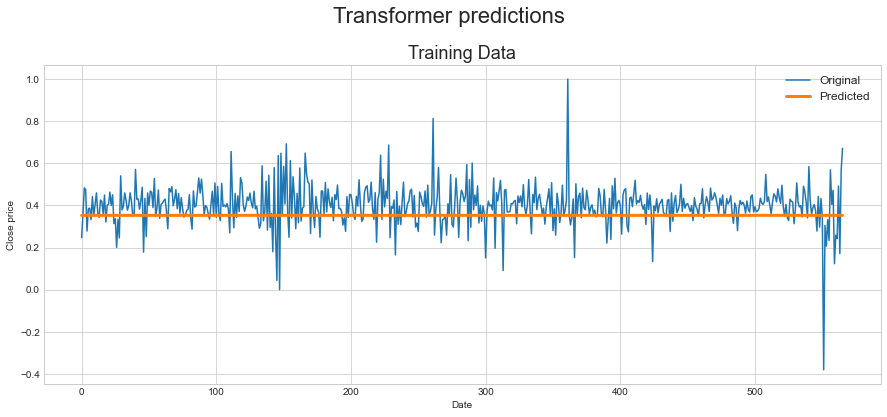

In [42]:
original, predictions = predict(simple_model_time2vec_conv, [loader_train_normal, loader_valid, loader_test])
draw_prediction(original, predictions)
# print(original)
print(f"Pred: {predictions}")

## Advanced model with Time2Vec and Conv layers

In [419]:
class ModelConvTimeTransformer(nn.Module):
    
    def __init__(self, sequence_lenght, num_features, num_encoder_layers=10, dropout=0.1):
        """
        Main model for stock price prediction.

        Args:
            num_features: the number of expected features in the input
            num_heads: the number of heads in the multiheadattention models
            num_encoder_layers: number of encoder layers
        """
        super(ModelConvTimeTransformer, self).__init__()

        # number of features should be divisible by num_heads
        encoder_features = num_features + num_features * 2
        num_heads=encoder_features
        self.time_embedding = Time2Vector(sequence_lenght, num_features)
        # layer = nn.TransformerEncoderLayer(d_model=num_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        layer = nn.TransformerEncoderLayer(d_model=encoder_features, nhead=num_heads, batch_first=True, layer_norm_eps=1e-6, dropout=dropout)
        self.encoder = nn.TransformerEncoder(layer, num_layers=num_encoder_layers)
        self.conv = nn.Conv1d(sequence_lenght, int(2*sequence_lenght), 1)
        self.poll = nn.MaxPool1d(2)
        self.conv1 = nn.Conv1d(int(2*sequence_lenght), 512, 1)
        self.dropout = nn.Dropout(p=dropout)
        # self.linear = nn.Linear(512, 64)
        self.linear = nn.Linear(3072, 512)
        self.dropout1 = nn.Dropout(p=dropout)
        self.linear1 = nn.Linear(512, 1)

        # convolved = Conv1D(nb_filters, fsize, padding="same", activation="tanh")(input_seq)
        # processed = GlobalMaxPooling1D()(convolved)
        # #dense layer with dropout regularization
        # compressed = Dense(50, activation="tanh")(processed)


    def forward(self, input):
        x = self.time_embedding(input)
        x = torch.cat([input, x], 2)
        x = self.encoder(x)
        x = self.conv(x)
        x = self.poll(x)
        x = self.conv1(x)
        # x = torch.squeeze(x, dim=2)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.linear(x))
        x = self.dropout1(x)
        x = self.linear1(x)
        return x

Epoch 1
-------------------------------
Train loss: 0.043360

Test loss: 0.090003
Epoch 2
-------------------------------
Train loss: 0.364629

Test loss: 0.195694
Epoch 3
-------------------------------
Train loss: 0.066938

Test loss: 0.020181
Epoch 4
-------------------------------
Train loss: 0.134875

Test loss: 0.053356
Epoch 5
-------------------------------
Train loss: 0.117208

Test loss: 0.070306
Epoch 6
-------------------------------
Train loss: 0.096432

Test loss: 0.049023
Epoch 7
-------------------------------
Train loss: 0.105115

Test loss: 0.050969
Epoch 8
-------------------------------
Train loss: 0.105638

Test loss: 0.054506
Epoch 9
-------------------------------
Train loss: 0.099844

Test loss: 0.045944
Epoch 10
-------------------------------
Train loss: 0.089509

Test loss: 0.023453
Epoch 11
-------------------------------
Train loss: 0.040341

Test loss: 0.010491
Epoch 12
-------------------------------
Train loss: 0.035382

Test loss: 0.070378
Epoch 13
----

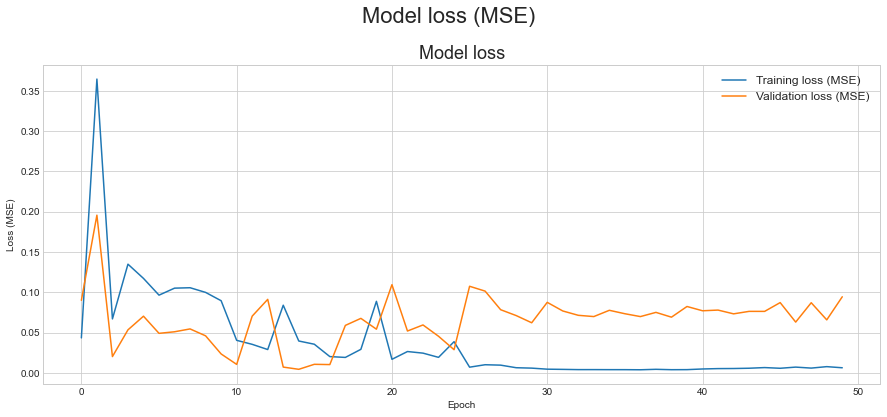

In [432]:
# default parameters
# lr=0.0001 (lr=0.001)
# layer_norm_eps=1e-6
# epochs = 100
# feature_num = 3
# num_encoder_layers=6
# dropout=0.1
# seq_len = 5
# Train loss: 0.006031
# Test loss: 0.012647 

## 1 parameters
# lr=0.00001
feature_num = 4
epochs = 50
model_conv_time2vec = ModelConvTimeTransformer(seq_len, feature_num)
# train_losses, valid_losses = train_model(model_conv_time2vec, loader_train, loader_valid, epochs=epochs, lr=0.0001)
train_losses, valid_losses = train_model(model_conv_time2vec, loader_train, loader_valid, epochs=epochs, lr=0.0001)
plot_losses(train_losses, valid_losses)

X: tensor([[[0.0208, 0.2572, 0.6032, 0.4308],
         [0.0263, 0.2047, 0.6133, 0.5075],
         [0.0344, 0.2321, 0.6319, 0.6044],
         ...,
         [0.0646, 0.0365, 0.5631, 0.4691],
         [0.0582, 0.1402, 0.5293, 0.3950],
         [0.0648, 0.2041, 0.6165, 0.4688]],

        [[0.0263, 0.2047, 0.6133, 0.5075],
         [0.0344, 0.2321, 0.6319, 0.6044],
         [0.0351, 0.2900, 0.5775, 0.6126],
         ...,
         [0.0582, 0.1402, 0.5293, 0.3950],
         [0.0648, 0.2041, 0.6165, 0.4688],
         [0.0718, 0.2227, 0.6186, 0.5395]],

        [[0.0344, 0.2321, 0.6319, 0.6044],
         [0.0351, 0.2900, 0.5775, 0.6126],
         [0.0358, 0.2881, 0.5772, 0.6208],
         ...,
         [0.0648, 0.2041, 0.6165, 0.4688],
         [0.0718, 0.2227, 0.6186, 0.5395],
         [0.0678, 0.1310, 0.5457, 0.4897]],

        ...,

        [[0.0646, 0.0365, 0.5631, 0.4691],
         [0.0582, 0.1402, 0.5293, 0.3950],
         [0.0648, 0.2041, 0.6165, 0.4688],
         ...,
         [0.1080, 

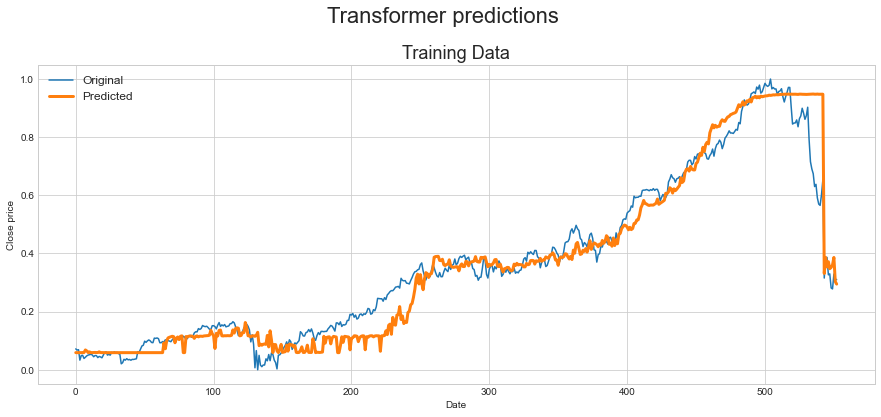

In [433]:
original, predictions = predict(model_conv_time2vec, [loader_train_normal, loader_valid, loader_test])
draw_prediction(original, predictions)
# draw_prediction(predictions)
print(f"Pred: {predictions}")

## Model with feature tranformation